In [22]:
import pandas as pd
import os
import ast 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import tqdm
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
# Read necessary csv's into dataframes
currDir = os.getcwd()
print("Working Directory:", currDir)

wordEmbeddingsPath = "subject_word_embeddings.csv"
subject_word_embeddings = pd.read_csv(wordEmbeddingsPath)
subject_word_embeddings.head()

objects_path = "StartupData/objects.csv"
objects_df = pd.read_csv(objects_path)
objects_df.head(10)

relationships_path = "StartupData/relationships.csv"
relationships_df = pd.read_csv(relationships_path)
relationships_df.head()

degrees_path = "StartupData/degrees.csv"
degrees_df = pd.read_csv(degrees_path)
degrees_df.head()

acquistions_path = "StartupData/acquisitions.csv"
acquisitions_df = pd.read_csv(acquistions_path)

Working Directory: /home/linus/WashUCoding/DIS Copenhagen/Data Science/FinalProject


/tmp/ipykernel_23173/2583637615.py:10: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects_df = pd.read_csv(objects_path)


In [4]:
# computes the distance between two vectors
# metric can be either "cosine" or "euclidean"
# note: vectors must be normalized (OpenAI's embedding vectors are normalized by default)
def calculateDistance(vector1, vector2, metric="cosine"): 
    if metric != "cosine" and metric != "euclidean": 
        print(metric, "is not an accepted metric. Please use either \"cosine\" or \"euclidean\"")
        return None

    vector1 = np.array(vector1)
    vector2 = np.array(vector2)
    if metric == "cosine": 
        return np.dot(vector1, vector2)
    else: 
        return np.linalg.norm(vector1 - vector2)
        

In [5]:
# used to lookup if a major has been embedded
embeddedMajors = set()

for index, row in subject_word_embeddings.iterrows(): 
    embeddedMajors.add(row["Subject"])

In [6]:
# normalize the subject fields to be all lowercase, have no periods and
# to be of length greater than 6 
degrees_df["subject"] = degrees_df["subject"].str.replace(".", "")
degrees_df["subject"] = degrees_df["subject"].str.lower()
degrees_df = degrees_df[degrees_df["subject"].str.len() >= 6]
all_majors = degrees_df[degrees_df["subject"].str.len() >= 6]["subject"].unique()

lengthSorted = sorted(all_majors, key = lambda x: len(x))

In [7]:
# used to lookup a person's major and retrieve that embedding
subject_to_embedding = {}
for i, row in subject_word_embeddings.iterrows(): 
    subject = row["Subject"]
    embedding = ast.literal_eval(row["Word Embedding"])
    subject_to_embedding[subject] = embedding

# could be used for general statistics of the data
embeddings_matrix = np.array(list(subject_to_embedding.values()))

In [8]:
# Filter DataFrame to contain only people/company relationships (not investment funds)
# assemble a dictionary with a CompanyCode and list of people codes
# assemble a dictionary of people code

# generate a series of dictionaries, each with only rows of their own type
# there are 4 types: companies, financial orgs, people, and products
id_to_name_companies = {}
name_to_id_companies = {}

id_to_name_financial_orgs = {}
name_to_id_financial_orgs = {}

id_to_name_people = {}
name_to_id_people = {}

id_to_name_products = {}
name_to_id_products = {}

for index, row in objects_df.iterrows(): 
    id = row["id"]
    name = row["normalized_name"]

    # c: companies
    if id.startswith("c:"): 
        id_to_name_companies[id] = name
        name_to_id_companies[name] = id

    # f: financial orgs
    elif id.startswith("f:"): 
        id_to_name_financial_orgs[id] = name
        name_to_id_financial_orgs[name] = id
    
    # p: people
    elif id.startswith("p:"): 
        id_to_name_people[id] = name
        name_to_id_people[name] = id
    
    # r: products
    elif id.startswith("r:"): 
        id_to_name_products[id] = name
        name_to_id_products[name] = id



In [9]:
# get dictionary of peopleCodes to the degrees they possess along with that degree's embedding
# contains a person code and a list of tuples with major and that major's embedding
# e.g. p:6136 -> [("english", [0.12, ...]), ("communications", [0.43, ...])]
peopleCodesToMajors = defaultdict(list)
for index, row in degrees_df.iterrows(): 
    peopleCode = row["object_id"]
    
    # normalize the major string to be same as inclusion criteria for 
    # obtaining a word embedding
    major = str(row["subject"])
    major = major.replace(".", "")
    major = major.lower()
    
    # only include people whose majors have been embedded
    if major in embeddedMajors: 
        peopleCodesToMajors[peopleCode].append((major, subject_to_embedding[major]))

# for key, val in peopleCodesToMajors.items(): 
#     print(key, len(val))

In [10]:
# create a dictionary with the key being a company code and the value being a list of 
# people associated with that company
companyCodeAndPeopleCodes = defaultdict(list)
for index, row in relationships_df.iterrows(): 
    companyCode = row["relationship_object_id"]
    personCode = row["person_object_id"]
    
    # only put companyCodes into the dictionary
    if not companyCode.startswith("c:"): 
        continue

    majors = peopleCodesToMajors[personCode]
    if len(majors) > 0: 
        companyCodeAndPeopleCodes[companyCode].append(personCode)

# for key, val in companyCodeAndPeopleCodes.items(): 
#     print(key, val)

mean: 2.3314015261276926
total number of people: 72471
median: 1

mean after filtering: 10.050325430032544
median after filtering: 6
number of companies with 4 or more employees: 8604


Text(0.5, 1.0, 'Number of People at Companies')

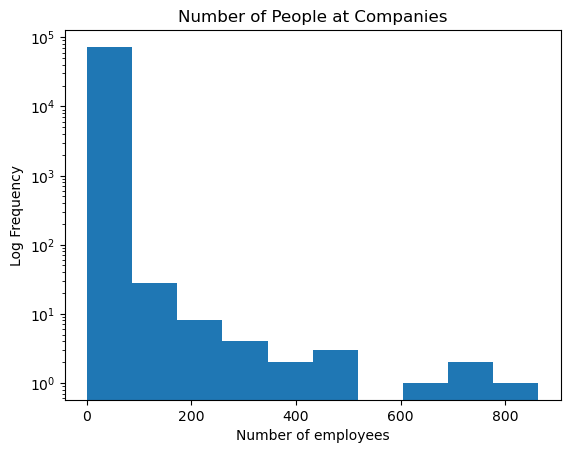

In [11]:
numberOfPeopleAtCompanies = [len(val) for val in companyCodeAndPeopleCodes.values()]
print("mean:", (sum(numberOfPeopleAtCompanies) / len(numberOfPeopleAtCompanies)))
print("total number of people:", len(numberOfPeopleAtCompanies))
print("median:", (list(sorted(numberOfPeopleAtCompanies))[len(numberOfPeopleAtCompanies)//2]))
print()

# filtering with a cutoff of 4 cuts the number of companies that can be analyzed
moreThan3Members = list(filter((lambda x: x >= 4), numberOfPeopleAtCompanies))
print("mean after filtering:", (sum(moreThan3Members) / len(moreThan3Members)))
print("median after filtering:", (list(sorted(moreThan3Members))[len(moreThan3Members)//2]))

print("number of companies with 4 or more employees:", len(moreThan3Members))
plt.hist(numberOfPeopleAtCompanies, log=True)
plt.xlabel("Number of employees")
plt.ylabel("Log Frequency")
plt.title("Number of People at Companies")

In [12]:
# dictionary containing only companies which had 4 or more people
companiesToStudy = defaultdict(list)
for key, val in companyCodeAndPeopleCodes.items(): 
    if len(val) < 4: 
        continue
    companiesToStudy[key] = val
print("Number of companies that met criteria:", len(companiesToStudy))
print("Criteria was a company having at least 4 members listed in relationships.csv")

Number of companies that met criteria: 8604
Criteria was a company having at least 4 members listed in relationships.csv


In [13]:
# how many of these companies have been acquired? 
relevantCompanyCodes = companiesToStudy.keys()
numCompaniesAcquiring = 0
numCompaniesAcquired = 0
for index, row in acquisitions_df.iterrows(): 
    acquiring_object_id = row["acquiring_object_id"]
    acquired_object_id = row["acquired_object_id"]
    acquisition_cost_in_millions = row["price_amount"] // 1_000_000
    acquisition_currency = row["price_currency_code"]

    if acquired_object_id in relevantCompanyCodes: 
        numCompaniesAcquired += 1
    if acquiring_object_id in relevantCompanyCodes: 
        numCompaniesAcquiring += 1

print("Total number of acquired companies:", numCompaniesAcquired)
print("Total number of acquirer companies:", numCompaniesAcquiring)

Total number of acquired companies: 1295
Total number of acquirer companies: 5238


> Most companies with 5 or more members listed are acquirers, but there are 2000 or so which have 5 or more people and have been acquired. 

> TODO: analyze what these numbers look like without filtering by 5 members, either choosing no filter or a smaller filter closer to the mean/median, perhaps 3 members

Number of Acquiring Companies in dataset: 1306
Number of Acquired Companies in dataset: 970
Number of neither: 6053
Number of both: 275
Sanity check: 8604


Text(0.5, 1.0, 'Size of Company Categories')

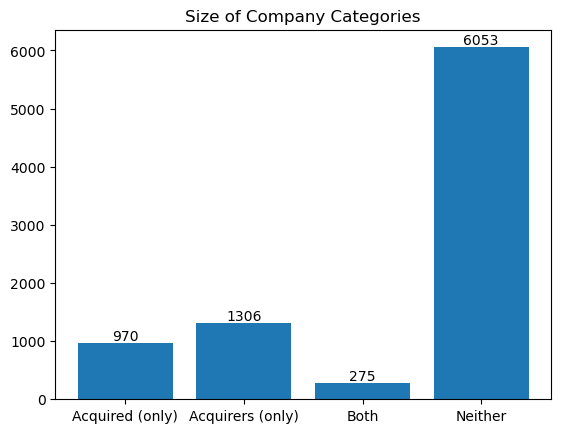

In [14]:
# Assemble sets which contain company codes of each category
setOfAcquirers = set()
setOfAcquired = set()
setOfNeither = set()

for index, row in acquisitions_df.iterrows(): 
    acquiring_object_id = row["acquiring_object_id"]
    acquired_object_id = row["acquired_object_id"]

    if acquiring_object_id in relevantCompanyCodes: 
        setOfAcquirers.add(acquiring_object_id)

    if acquired_object_id in relevantCompanyCodes: 
        setOfAcquired.add(acquired_object_id)

for companyCode in relevantCompanyCodes: 
    if companyCode not in setOfAcquirers and companyCode not in setOfAcquired: 
        setOfNeither.add(companyCode)

acquirersAndAcquired = setOfAcquirers.intersection(setOfAcquired)

# remove the companies which are both acquirers and acquired companies from the 
# dataset representing solely an acquired company or solely an acquirer company 
setOfAcquirers.difference_update(acquirersAndAcquired)
setOfAcquired.difference_update(acquirersAndAcquired)

print("Number of Acquiring Companies in dataset:", len(setOfAcquirers))
print("Number of Acquired Companies in dataset:", len(setOfAcquired))
print("Number of neither:", len(setOfNeither))
print("Number of both:", len(acquirersAndAcquired))
print("Sanity check:", len(setOfAcquirers) + len(setOfAcquired) + len(setOfNeither) + len(acquirersAndAcquired))

xLabels = ["Acquired (only)", "Acquirers (only)", "Both", "Neither"]
heights = [len(setOfAcquired), len(setOfAcquirers), len(acquirersAndAcquired), len(setOfNeither)]
fig, ax = plt.subplots()
bars = ax.bar(xLabels, heights)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Size of Company Categories")


In [14]:
# Takes in a list of peopleCodes and returns 3 numbers: the average cosine similarity between the 
# majors of all those people, the most similar comparison, and the least similar comparison
def calculateGroupDistance(peopleCodes): 
    totalCosineSimilarity, highest, lowest = 0.0, ("", float("-inf")), ("", float("+inf"))

    # assemble all majors and their embeddings for all people
    allMajorsAndEmbeddings = []
    for personCode in peopleCodes: 
        majorAndEmbedding = peopleCodesToMajors[personCode]

        # add all of somebody's degrees to the list, we effectively treat people
        # with multiple degrees as distinct individuals
        for majEmbed in majorAndEmbedding: 
            allMajorsAndEmbeddings.append(majEmbed)

    # print(list(x for x, _ in allMajorsAndEmbeddings))

    numberOfComparisons = 0 
    # calculate all pairs' cosine similarities
    # a lovely lovely O(n^2) algorithm :/
    for i in range(len(allMajorsAndEmbeddings) - 1): 
        embedding1 = allMajorsAndEmbeddings[i]
        for j in range(i+1, len(allMajorsAndEmbeddings)): 
            embedding2 = allMajorsAndEmbeddings[j]
            comparisonStr = str(embedding1[0] + ":" + embedding2[0])
            distance = calculateDistance(embedding1[1], embedding2[1])

            # print(comparisonStr, distance)

            # determine the return values
            totalCosineSimilarity += distance
            # added a threshold so the cosine similarity of the exact same word is ignored
            if distance > highest[1] and abs(distance - 1.0) > 0.00001: 
                highest = (comparisonStr, distance)
            if distance < lowest[1]: 
                lowest = (comparisonStr, distance)
            numberOfComparisons += 1

    avgCosineSimilarity = totalCosineSimilarity / numberOfComparisons
    return avgCosineSimilarity, highest, lowest

In [16]:
# TODO: Can try calculating Centroid-Based Similarity. To do this: do the following
# (1) Calculate the mean vector of all embedding vectors within a group
# (2) Compute the cosine similarity of all embeddings with that central vector
def calculateCentroidSimilarity(peopleCodes): 
    totalCosineSimilarity, highest, lowest = 0.0, ("", float("-inf")), ("", float("+inf"))

    # assemble all majors and their embeddings for all people
    allMajorsAndEmbeddings = []
    for personCode in peopleCodes: 
        majorAndEmbedding = peopleCodesToMajors[personCode]

        # add all of somebody's degrees to the list, we effectively treat people
        # with multiple degrees as distinct individuals
        for majEmbed in majorAndEmbedding: 
            allMajorsAndEmbeddings.append(majEmbed)

    allEmbeddings = [embedding for _, embedding in allMajorsAndEmbeddings]

    # calculate normalized centroid vector
    non_normalized_centroid = [sum(elements) for elements in zip(*allEmbeddings)]
    lengthOfNonNormalized = (sum(num**2 for num in non_normalized_centroid)) ** 0.5
    normalized_centroidVector = list(map(lambda x: x / lengthOfNonNormalized, non_normalized_centroid))
    # calculate all individual embedding vectors against the centroid 
    for majEmbed in allMajorsAndEmbeddings: 
        major, embedding = majEmbed
        distance = calculateDistance(normalized_centroidVector, embedding)

        totalCosineSimilarity += distance
        
        # for additional metrics, store the highest and lowest distances
        if distance > highest[1] and abs(distance - 1.0) > 0.00001: 
            highest = (major, distance)
        if distance < lowest[1]: 
            lowest = (major, distance)
    averageCosineSimilarity = totalCosineSimilarity / len(allMajorsAndEmbeddings)
    return averageCosineSimilarity, highest, lowest





In [18]:
# TODO: give the calculate centroid function a run through, make sure the average
# cosine similarity is correctly normalized to 1
# then compare results to calculating the pairwise cosine similarities
acquirerCentroidSim = []
acquiredCentroidSim = []
bothCentroidSim = []
neitherCentroidSim = []
overallLowest = ("", float("+inf"))
count = 0
for companyCode, peopleCodes in companiesToStudy.items(): 
    # if count > 4: 
    #     break 
    # count += 1
    # print(companyCode, peopleCodes)
    # print(len(peopleCodes))
    avgSim, highest, lowest = calculateCentroidSimilarity(peopleCodes)
    if lowest[1] < overallLowest[1]: 
        overallLowest = lowest
    
    if companyCode in setOfAcquirers: 
        acquirerCentroidSim.append(avgSim)
    elif companyCode in setOfAcquired: 
        acquiredCentroidSim.append(avgSim)
    elif companyCode in acquirersAndAcquired: 
        bothCentroidSim.append(avgSim)
    elif companyCode in setOfNeither: 
        neitherCentroidSim.append(avgSim)
print(len(acquirerCentroidSim) + len(acquiredCentroidSim) + len(bothCentroidSim) + len(neitherCentroidSim))
# print("most disimilar majors:", overallLowest)

8604
most disimilar majors: ('information systems, entrepreneurial studies and innovation management, industrial marketing-management', -0.01241906932315504)


In [17]:
# Obtain pairwise cosine similarity averages
acquirerAvgSims = []
acquiredAvgSims = []
bothAvgSims = []
neitherAvgSims = []

count = 0
for companyCode, peopleCodes in companiesToStudy.items(): 
    # if count > 4: 
    #     break 
    # print(companyCode, peopleCodes)
    # print(len(peopleCodes))
    avgSim, highestSim, lowestSim = calculateGroupDistance(peopleCodes)

    if companyCode in setOfAcquirers: 
        acquirerAvgSims.append(avgSim)
    elif companyCode in setOfAcquired: 
        acquiredAvgSims.append(avgSim)
    elif companyCode in acquirersAndAcquired: 
        bothAvgSims.append(avgSim)
    elif companyCode in setOfNeither: 
        neitherAvgSims.append(avgSim)
print(len(acquirerAvgSims) + len(acquiredAvgSims) + len(bothAvgSims) + len(neitherAvgSims))

8604


(0.65, 1.05)

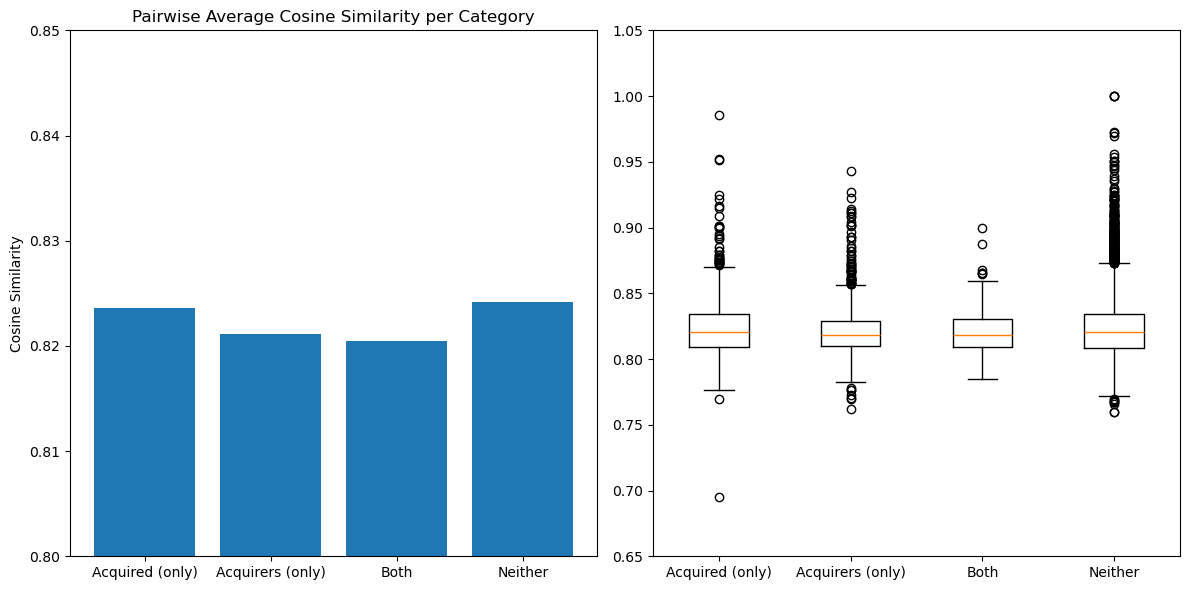

In [41]:
# Pairwise cosine similarity bar plot
averages = [sum(acquiredAvgSims)/len(acquiredAvgSims), 
            sum(acquirerAvgSims)/len(acquirerAvgSims), 
            sum(bothAvgSims) / len(bothAvgSims), 
            sum(neitherAvgSims) / len(neitherAvgSims)]

# fig1, ax1 = plt.subplots()
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.bar(xLabels, averages)
plt.title("Pairwise Average Cosine Similarity per Category")
plt.ylabel("Cosine Similarity")
plt.ylim(0.8, 0.85)

# avgBars = ax1.bar(xLabels, averages)
# for avgBars in ax1.containers:
#     ax1.bar_label(avgBars)

plt.subplot(1,2,2)
plt.boxplot([acquiredAvgSims, acquirerAvgSims, bothAvgSims, neitherAvgSims], labels=xLabels)
plt.ylim(0.65, 1.05)

[0.937437956499763, 0.9273425303429498, 0.9067649305239561, 0.9247551871555372, 0.9195784513655026, 0.901395233306319, 0.9137447379817194, 0.9127784862184118, 0.9298436530090605, 0.9102654477482377, 0.9402735463746195, 0.9124600442720125, 0.9099330775717361, 0.9008226079940568, 0.9190589776075025, 0.9097190805677895, 0.9198937105857125, 0.9074211081008873, 0.9059728964320564, 0.9125244112381339, 0.9084159430146335, 0.9173131087264031, 0.9147284293306792, 0.9445812931010188, 0.9284857373770329, 0.9327807287690314, 0.9005206912338332, 0.9104021123116041, 0.9090127882635712, 0.9144661521450378, 0.9262557389409695, 0.9165596852295385, 0.9095004664261934, 0.9172376220062397, 0.9156367532804607, 0.9132671716841508, 0.9201003467563167, 0.9200039882076965, 0.913687704441716, 0.9142307207317846, 0.9186628815008065, 0.9285221867071104, 0.9235961164456495, 0.9135861292441515, 0.9154535001123227, 0.9258349736857028, 0.9066374557838698, 0.9166863965255864, 0.9300668594306508, 0.9034835691462388, 0.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1ef78b82d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1ef78b9710>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1ef2da6d50>,
 'medians': [<matplotlib.lines.Line2D at 0x7f1ef78ba690>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1ef78bae90>,
 'means': []}

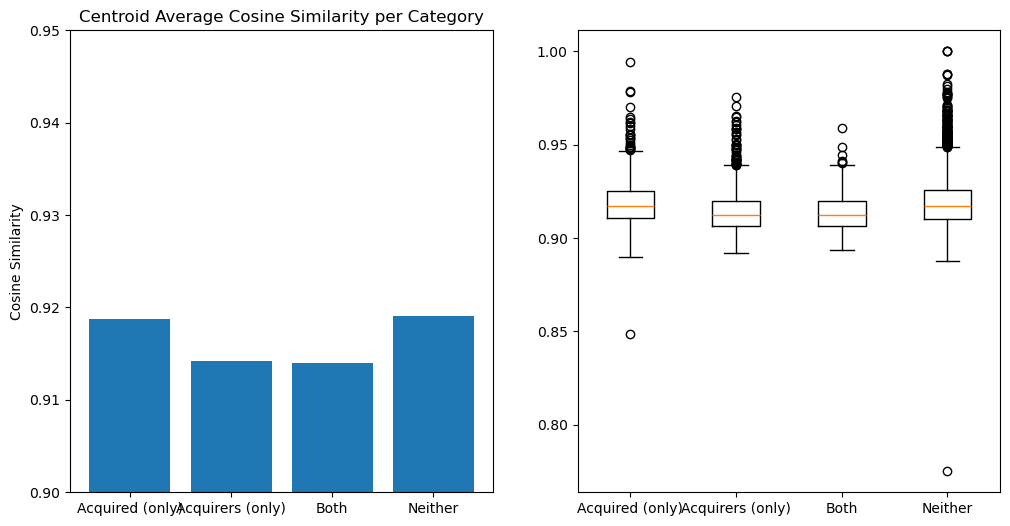

In [19]:
print(acquiredCentroidSim)
avgCentroidSims = [sum(acquiredCentroidSim)/len(acquiredCentroidSim), 
            sum(acquirerCentroidSim)/len(acquirerCentroidSim), 
            sum(bothCentroidSim) / len(bothCentroidSim), 
            sum(neitherCentroidSim) / len(neitherCentroidSim)]


# fig, ax = plt.subplots()
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.bar(xLabels, avgCentroidSims)
plt.title("Centroid Average Cosine Similarity per Category")
plt.ylabel("Cosine Similarity")
plt.ylim(0.9, 0.95)

# avgBars = ax.bar(xLabels, avgCentroidSims)
# for avgBars in ax.containers:
#     ax.bar_label(avgBars)

plt.subplot(1,2,2)
plt.boxplot([acquiredCentroidSim, acquirerCentroidSim, bothCentroidSim, neitherCentroidSim], labels=xLabels)


In [62]:
# statistical tests on Centroid similarities

pValues = []
category_pairs = [('Acquired', 'Acquirer', acquiredCentroidSim, acquirerCentroidSim),
                  ('Acquired', 'Both', acquiredCentroidSim, bothCentroidSim),
                  ('Acquired', 'Neither', acquiredCentroidSim, neitherCentroidSim),
                  ('Acquirer', 'Both', acquirerCentroidSim, bothCentroidSim),
                  ('Acquirer', 'Neither', acquirerCentroidSim, neitherCentroidSim),
                  ('Both', 'Neither', bothCentroidSim, neitherCentroidSim)]

# VERIFY THIS IS ACCURATE!!!
for cat1, cat2, means1, means2 in category_pairs: 
    t_stat, pVal = stats.ttest_ind(means1, means2)
    pValues.append((cat1, cat2, pVal))
    print((cat1, cat2, pVal))
    print("t:", t_stat)

('Acquired', 'Acquirer', 1.0239572898149532e-19)
t: 9.170500950772404
('Acquired', 'Both', 7.3566737391232825e-09)
t: 5.822865243850015
('Acquired', 'Neither', 0.4767311414513098)
t: -0.7116080845655058
('Acquirer', 'Both', 0.7659380511598887)
t: 0.2977435758240417
('Acquirer', 'Neither', 3.573121537267644e-36)
t: -12.626478398885986
('Both', 'Neither', 1.3791482036755986e-10)
t: -6.428895390572158


In [43]:
# from: https://stackoverflow.com/questions/11517986/indicating-the-statistically-significant-difference-in-bar-graph
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break
            elif len(text) > 2: 
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


means: [0.9187806475954032, 0.914253167246071, 0.9140359184051119, 0.9190953740963678]
stds: [0.012318105242529484, 0.011114050519330402, 0.010382889360319641, 0.012859593756052109]
lengths: [970, 1306, 275, 6053]
9.036741776600184


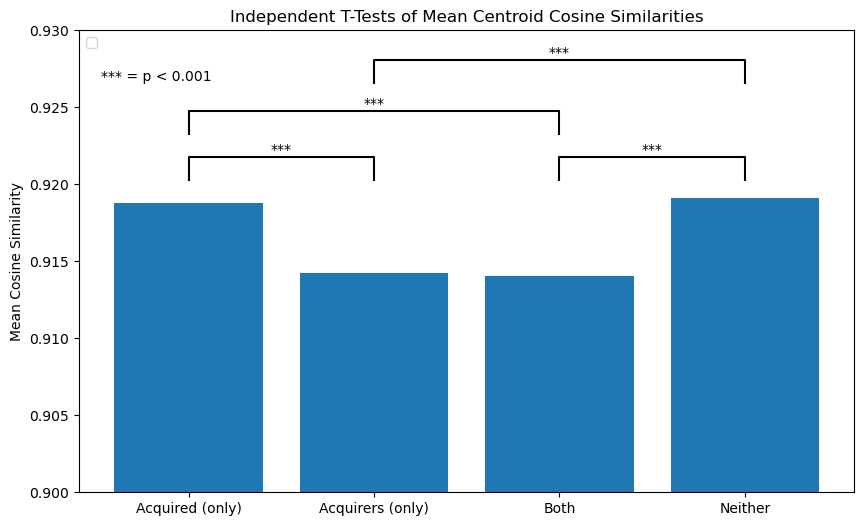

In [81]:
# Bonferroni Correction
alpha = 0.05
n_comparisons = len(pValues)
bonferroni_alpha = alpha / n_comparisons

# Calculate the means for each category
mean_values = [np.mean(acquiredCentroidSim), np.mean(acquirerCentroidSim), 
               np.mean(bothCentroidSim), np.mean(neitherCentroidSim)]
standardDevs = [np.std(acquiredCentroidSim), np.std(acquirerCentroidSim), 
                np.std(bothCentroidSim), np.std(neitherCentroidSim)]
nValues = [len(acquiredCentroidSim), len(acquirerCentroidSim), len(bothCentroidSim), len(neitherCentroidSim)]
print("means:", mean_values)
print("stds:", standardDevs)
print("lengths:", nValues)

heights = mean_values
bars = np.arange(len(heights))

plt.figure(figsize=(10, 6))
plt.bar(xLabels, heights)
plt.ylim(0.9, 0.93)
plt.title("Independent T-Tests of Mean Centroid Cosine Similarities")
plt.ylabel("Mean Cosine Similarity")
plt.legend(loc='upper left')
plt.text(0.1, 0.95, "*** = p < 0.001", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
barplot_annotate_brackets(0, 1, pValues[0][2], bars, heights)
barplot_annotate_brackets(0, 2, pValues[1][2], bars, heights, dh=0.15)
barplot_annotate_brackets(1, 3, pValues[4][2], bars, heights, dh=0.25)
barplot_annotate_brackets(2, 3, pValues[5][2], bars, heights, dh=0.04)
t_stat = (mean_values[0] - mean_values[1]) / (standardDevs[0]**2 / nValues[0] + standardDevs[1]**2/nValues[1]) ** 0.5
print(t_stat)

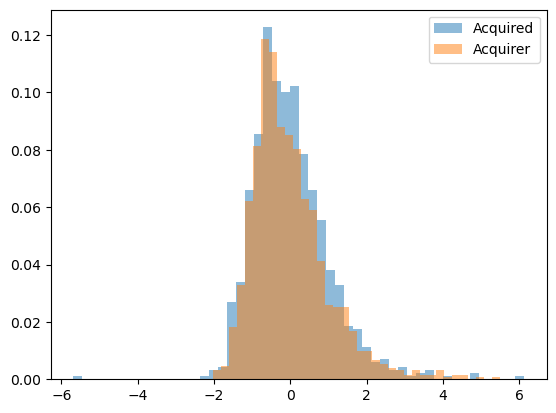

In [73]:
import random
import numpy
from matplotlib import pyplot

def zNormalizeList(elements): 
    mean = np.mean(elements)
    std = np.std(elements)
    normalizedList = [(x - mean) / std for x in elements]
    return normalizedList

acquiredCentroidSim_norm = zNormalizeList(acquiredCentroidSim)
acquirerCentroidSim_norm = zNormalizeList(acquirerCentroidSim)

binCounts1, binEdges1 = np.histogram(acquiredCentroidSim_norm, bins="auto", density=True)
binCounts2, binEdges2 = np.histogram(acquirerCentroidSim_norm, bins="auto", density=True)

binWidths1 = np.diff(binEdges1)
binWidths2 = np.diff(binEdges2)

normalizedHeights1 = binCounts1 * binWidths1
normalizedHeights2 = binCounts2 * binWidths2

plt.bar(binEdges1[:-1], normalizedHeights1, width = binWidths1, align="edge", alpha = 0.5, label = "Acquired")
plt.bar(binEdges2[:-1], normalizedHeights2, width = binWidths2, align="edge", alpha = 0.5, label = "Acquirer")
plt.legend(loc='upper right')
# pyplot.hist(acquiredCentroidSim_norm, bins, alpha=0.5, label='x')
# pyplot.hist(acquirerCentroidSim_norm, bins, alpha=0.5, label='y')
# pyplot.legend(loc='upper right')
# pyplot.show()